Structuring dataset

In [ ]:
import os
import shutil

# Set paths
dataset_root = "D:/TpRN/Projet/archive (2)/HG14/HG14-Hand Gesture"   
output_folder = "./all_images"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Loop through each class subfolder
img_count = 0
for class_name in os.listdir(dataset_root):
    class_folder = os.path.join(dataset_root, class_name)
    if not os.path.isdir(class_folder):
        continue

    for filename in os.listdir(class_folder):
        file_path = os.path.join(class_folder, filename)

        # Check if it's an image file
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            new_filename = f"{class_name}_{img_count}.jpg"
            shutil.copy(file_path, os.path.join(output_folder, new_filename))
            img_count += 1

print(f"Moved {img_count} images to '{output_folder}'")


detecting hands with mediapipe

In [ ]:
import cv2
import os
import mediapipe as mp

# Paths
image_dir = "./all_images"       # Folder with all gesture images
label_dir = "./labels"           # Output label folder (YOLO format)
os.makedirs(label_dir, exist_ok=True)

# MediaPipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

def get_yolo_bbox(landmarks, image_width, image_height):
    # Get min/max x and y from landmarks
    x_coords = [lm.x * image_width for lm in landmarks]
    y_coords = [lm.y * image_height for lm in landmarks]
    
    x_min = min(x_coords)
    x_max = max(x_coords)
    y_min = min(y_coords)
    y_max = max(y_coords)

    # Calculate YOLO format
    x_center = (x_min + x_max) / 2 / image_width
    y_center = (y_min + y_max) / 2 / image_height
    width = (x_max - x_min) / image_width
    height = (y_max - y_min) / image_height

    return x_center, y_center, width, height

# Process images
for filename in os.listdir(image_dir):
    if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img_path = os.path.join(image_dir, filename)
    img = cv2.imread(img_path)
    h, w, _ = img.shape

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    if result.multi_hand_landmarks:
        # Take the first detected hand
        hand_landmarks = result.multi_hand_landmarks[0]
        x_c, y_c, w_b, h_b = get_yolo_bbox(hand_landmarks.landmark, w, h)

        # Save label file with class 0 (hand)
        label_path = os.path.join(label_dir, filename.rsplit(".", 1)[0] + ".txt")
        with open(label_path, "w") as f:
            f.write(f"0 {x_c:.6f} {y_c:.6f} {w_b:.6f} {h_b:.6f}\n")

print("✅ Bounding box generation complete.")


Plotting examples

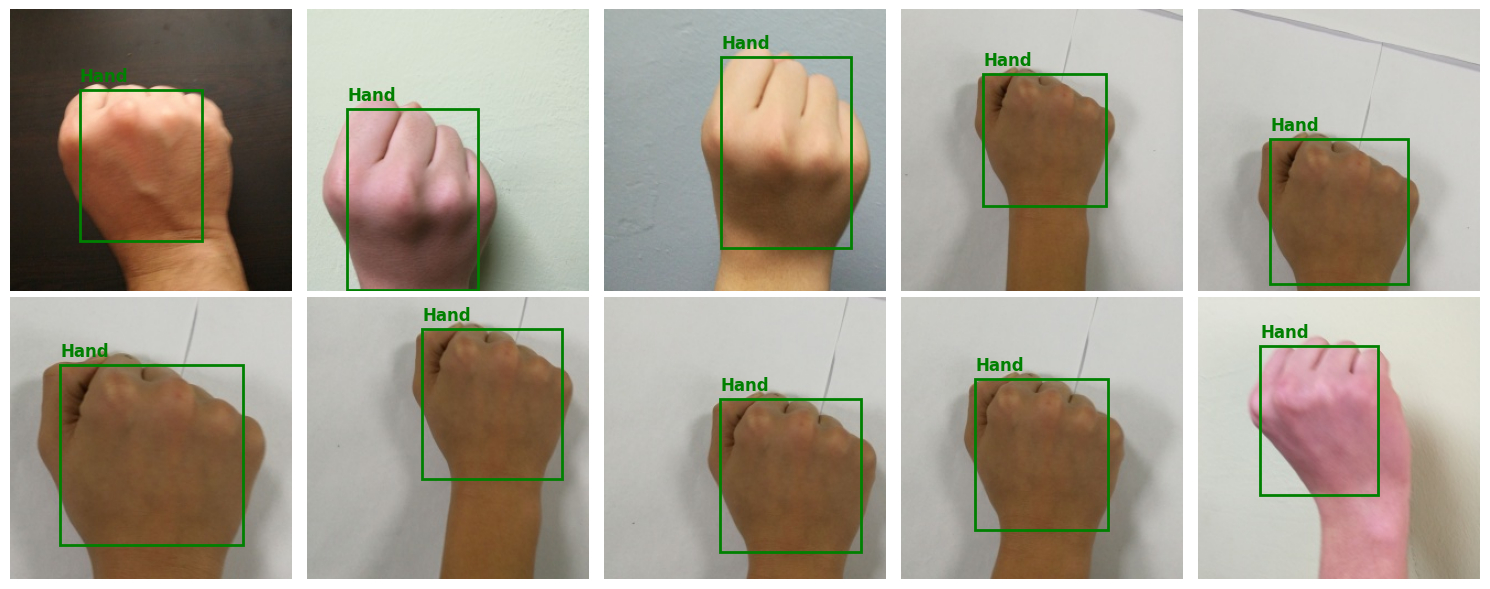

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Paths
image_dir = "./dataset/images/train/"
label_dir = "./dataset/labels/train/"

# Function to convert YOLO bbox to pixel coordinates
def yolo_to_pixel_coords(x_center, y_center, width, height, img_w, img_h):
    x_min = int((x_center - width / 2) * img_w)
    x_max = int((x_center + width / 2) * img_w)
    y_min = int((y_center - height / 2) * img_h)
    y_max = int((y_center + height / 2) * img_h)
    return x_min, y_min, x_max, y_max

# Visualize first 10 labeled images
count = 0
images = []  # To store the images for plotting
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Create a grid of subplots (2 rows, 5 columns)

for ax in axes.flatten():  # Flatten the axes array to easily iterate over
    if count >= 10:
        break  # Stop after 10 images

    filename = sorted(os.listdir(image_dir))[count]
    if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
        count += 1
        continue

    img_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

    if not os.path.exists(label_path):
        count += 1
        continue  # Skip images without labels

    img = cv2.imread(img_path)
    if img is None:
        count += 1
        continue
    img_h, img_w = img.shape[:2]

    # Convert the image from BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img_rgb)

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            class_id, x_c, y_c, w, h = map(float, parts)
            x_min, y_min, x_max, y_max = yolo_to_pixel_coords(x_c, y_c, w, h, img_w, img_h)

            # Create a rectangle patch
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)

            # Add label text
            ax.text(x_min, y_min - 8, "Hand", color='green', fontsize=12, weight='bold')

    ax.axis('off')  # Remove axes for better visualization
    count += 1

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


dataset Cleaning

In [ ]:
import os
import shutil

# Original paths
image_dir = "./all_images"
label_dir = "./labels"

# New cleaned dataset paths
clean_image_dir = os.path.join("dataset", "images")
clean_label_dir = os.path.join("dataset", "labels")

# Create directories if they don't exist
os.makedirs(clean_image_dir, exist_ok=True)
os.makedirs(clean_label_dir, exist_ok=True)

# Count how many were copied
valid_count = 0
skipped_count = 0

for filename in os.listdir(image_dir):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    image_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

    # Check if label file exists
    if not os.path.exists(label_path):
        skipped_count += 1
        continue

    # Check if label file has valid content (YOLO format = 5 elements per line)
    with open(label_path, "r") as f:
        lines = f.readlines()
        valid_lines = [line for line in lines if len(line.strip().split()) == 5]

    if not valid_lines:
        skipped_count += 1
        continue

    # Copy valid image and label
    shutil.copy(image_path, os.path.join(clean_image_dir, filename))
    shutil.copy(label_path, os.path.join(clean_label_dir, os.path.splitext(filename)[0] + ".txt"))
    valid_count += 1

print(f"✅ Cleaned dataset created.")
print(f"✔️  {valid_count} image-label pairs copied to 'dataset/images' and 'dataset/labels'.")
print(f"❌  {skipped_count} images skipped due to missing or invalid labels.")
